# Nettoyage du jeu de données de OpenFoodFacts

Import des bibliothèques

In [1101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

Lecture du fichier CSV

In [1102]:
data = pd.read_csv('fr.openfoodfacts.org.products.csv', encoding='utf-8', sep='\t')

C:\Users\vkubi\AppData\Local\Temp\ipykernel_20748\3747638330.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('fr.openfoodfacts.org.products.csv', encoding='utf-8', sep='\t')


In [1103]:
data.dtypes

code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

In [1104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


In [1105]:
data.describe()

no_nutriments    additives_n  ingredients_from_palm_oil_n  \
count            0.0  248939.000000                248939.000000   
mean             NaN       1.936024                     0.019659   
std              NaN       2.502019                     0.140524   
min              NaN       0.000000                     0.000000   
25%              NaN       0.000000                     0.000000   
50%              NaN       1.000000                     0.000000   
75%              NaN       3.000000                     0.000000   
max              NaN      31.000000                     2.000000   

       ingredients_from_palm_oil  ingredients_that_may_be_from_palm_oil_n  \
count                        0.0                            248939.000000   
mean                         NaN                                 0.055246   
std                          NaN                                 0.269207   
min                          NaN                                 0.000000   
25%                          NaN                                 0.000000   
50%                          NaN                                 0.000000   
75%                          NaN                                 0.000000   
max                          NaN                                 6.000000   

       ingredients_that_may_be_from_palm_oil  nutrition_grade_uk  \
count                                    0.0                 0.0   
mean                                     NaN                 NaN   
std                                      NaN                 NaN   
min                                      NaN                 NaN   
25%                                      NaN                 NaN   
50%                                      NaN                 NaN   
75%                                      NaN                 NaN   
max                                      NaN                 NaN   

        energy_100g  energy-from-fat_100g       fat_100g  ...    ph_100g  \
count  2.611130e+05            857.000000  243891.000000  ...  49.000000   
mean   1.141915e+03            585.501214      12.730379  ...   6.425698   
std    6.447154e+03            712.809943      17.578747  ...   2.047841   
min    0.000000e+00              0.000000       0.000000  ...   0.000000   
25%    3.770000e+02             49.400000       0.000000  ...   6.300000   
50%    1.100000e+03            300.000000       5.000000  ...   7.200000   
75%    1.674000e+03            898.000000      20.000000  ...   7.400000   
max    3.251373e+06           3830.000000     714.290000  ...   8.400000   

       fruits-vegetables-nuts_100g  collagen-meat-protein-ratio_100g  \
count                  3036.000000                        165.000000   
mean                     31.458587                         15.412121   
std                      31.967918                          3.753028   
min                       0.000000                          8.000000   
25%                       0.000000                         12.000000   
50%                      23.000000                         15.000000   
75%                      51.000000                         15.000000   
max                     100.000000                         25.000000   

       cocoa_100g  chlorophyl_100g  carbon-footprint_100g  \
count  948.000000              0.0             268.000000   
mean    49.547785              NaN             341.700764   
std     18.757932              NaN             425.211439   
min      6.000000              NaN               0.000000   
25%     32.000000              NaN              98.750000   
50%     50.000000              NaN             195.750000   
75%     64.250000              NaN             383.200000   
max    100.000000              NaN            2842.000000   

       nutrition-score-fr_100g  nutrition-score-uk_100g  glycemic-index_100g  \
count            221210.000000            221210.000000                  0.0   
mean                  9.165535             

D'après le fichier de description certains noms de colonne ont des terminaisons qui indiquent quel est censé être le type de données. '_t' pour les timestamp pas exemple

J'essaie de corriger le type des colonnes de type date dans un premier temps. Changer le type directement n'a pas fonctionné, je corrige donc les erreurs et cast par la suite.

In [1106]:
timestamp_columns = [x for x in data.columns if x.endswith('_t')]

min_time = pd.Timestamp.min
max_time = pd.Timestamp.max

for i in timestamp_columns:
    # Corrige les erreurs,
    data[i] = pd.to_numeric(data[i], errors='coerce')
    data.loc[(data[i] > max_time.value), i].isna()
    data.loc[(data[i] < min_time.value), i].isna()
    # Cast une fois les erreurs corrigées
    data[i] = pd.to_datetime(data[i])
data[timestamp_columns].dtypes

created_t          datetime64[ns]
last_modified_t    datetime64[ns]
dtype: object

Le changement de type est concluant, mais avant de m'affairer aux autres types, je vais essayer de vérifier si des colonnes sont vides ou s'il existe des doublons.
On supprime les colonnes qui sont vides

In [1107]:
print("Taille avant : ", data.shape)
data = data.dropna(axis=1, how='all')
data = data.dropna(axis=0, how='all')
print("Taille après : ", data.shape)

Taille avant :  (320772, 162)
Taille après :  (320772, 146)


**16 colonnes supprimées**

On vérifie s'il existe des doublons soit ayant le même 'code' ou ayant la même 'URL'. Je ne pense pas que les colonnes 'product_name' ou 'generic_name' puissent servir à identifier l'unicité d'un produit, car des produits similaires ne provenant pas de la même marque peuvent avoir des noms quasiment identiques.

In [1108]:
data[data.duplicated(subset=['code']) | data.duplicated(subset=['url'])].shape

(133, 146)

Il y a 133 doublons

In [1109]:
data = data.sort_values(by='created_t', ascending=True)
print('nombre de lignes avant : ', data.shape)
# Supprime les lignes en double en conservant seulement la première occurence
mask = data.duplicated(subset=['code']) | data.duplicated(subset=['url'])
data = data[~mask]
print('nombre de lignes après : ', data.shape)

nombre de lignes avant :  (320772, 146)
nombre de lignes après :  (320639, 146)


**Maintenant que nous avons purgé les données vides ou double, j'essaie de changer les types des données**

Les colonnes se terminant par '_datetime' sont des dates au format iso8601 format: **yyyy-mm-ddThh:mn:ssZ**

In [1110]:
datetime_columns = [x for x in data.columns if x.endswith('_datetime')]

data[datetime_columns].dtypes

created_datetime          object
last_modified_datetime    object
dtype: object

In [1111]:
data.iloc[320638]

code                                                              NaN
url                                                               NaN
creator                             villecomtal-sur-arros-gers-france
created_t                                                         NaT
created_datetime                                                  NaN
                                                  ...                
collagen-meat-protein-ratio_100g                                  NaN
cocoa_100g                                                        NaN
carbon-footprint_100g                                             NaN
nutrition-score-fr_100g                                           NaN
nutrition-score-uk_100g                                           NaN
Name: 189068, Length: 146, dtype: object

In [1112]:
# Suppression ligne
data = data.drop(data.index[320638])
# Nouvelle tentative de Cast
for i in datetime_columns:
     data[i] = pd.to_datetime(data[i])

# Vérification des types
data[datetime_columns].dtypes

created_datetime          datetime64[ns, UTC]
last_modified_datetime    datetime64[ns, UTC]
dtype: object

Les colonnes se terminant par '_tags' sont des listes séparées par des ',' et devraient donc être de type **object**

In [1113]:
tag_columns = [x for x in data.columns if x.endswith('_tags')]
data[tag_columns].dtypes

packaging_tags                                object
brands_tags                                   object
categories_tags                               object
origins_tags                                  object
manufacturing_places_tags                     object
labels_tags                                   object
emb_codes_tags                                object
cities_tags                                   object
countries_tags                                object
traces_tags                                   object
additives_tags                                object
ingredients_from_palm_oil_tags                object
ingredients_that_may_be_from_palm_oil_tags    object
states_tags                                   object
dtype: object

In [1114]:
amount_columns = [x for x in data.columns if x.endswith('_100g')]

Les montants sont tous bien de type **float64**
Maintenant vérifions la même chose pour les colonnes se terminant '_serving'

In [1115]:
serving_columns = [x for x in data.columns if x.endswith('_serving')]

Il n'y a plus de colonnes de ce type, donc les types de données sont maintenant corrects.

# Détection des variables intéressantes pour mon projet d'application
**- Une application de suivi alimentaire qui permet de savoir les apports calorifiques des repas en saisissant les produits avec lequel on les confectionne. On peut utiliser les colonnes (ingredients_txt, et toutes les colonnes _100g)**

**- Une application de recommandation de produits sains, elle permettrait de proposer une alternative plus saine à l'aide des colonnes (additives, additives_tags, additives_fr, additives_n, ingredients_from_palm_oil_n, ingredients_that_may_be_from_palm_oil_n, ingredients_that_may_be_from_palm_oil_tags, nutrition_grade_fr) et des tags similaire sur des produits (pnns_groups_1, pnns_group2, main_category, main_category, main_category_fr)**

**- Une application qui permet de voir l'origine des produits avec les colonnes (origins, origins_tags, manufacturing_places, manufacturing_places_tags, first_packaging_code_geo, cities, cities_tags)**

**- Une application de recherche de produits ne contenant pas de produits allergène pour l'utilisateur à l'aide de : (allergens, allergens_fr, ingredients_txt, traces, traces_tags, traces_fr)**

**À savoir que chaque ligne à un statut de vérification (states, states_tag, states_fr) cela pourrait influer sur le poids de l'utilisation de la donnée.**

---

## Repérer les variables pertinentes pour les traitements à venir (viser 15-20 variables) + sélection d'une seule idée

### Suppression de colonnes presque entièrement vides (80% de valeurs manquantes)


Nombre total de colonnes :  146


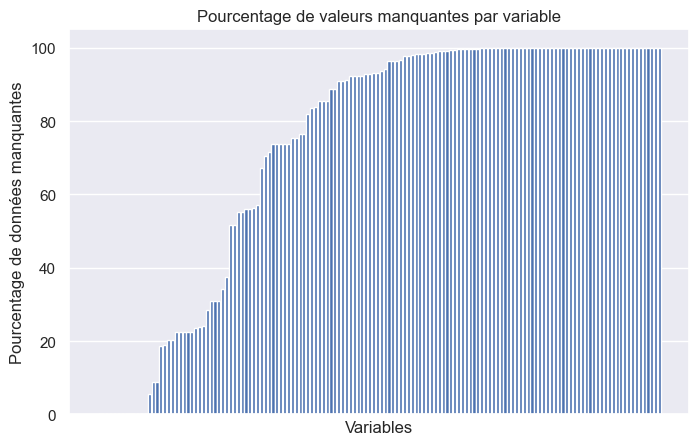

In [1116]:
percent_null = data.isnull().sum()*100/len(data)
percent_null = percent_null.sort_values(ascending=True)
print("Nombre total de colonnes : ", data.shape[1])
plt.bar(x=percent_null.keys(), height=percent_null.values)
plt.xticks(ticks=[])
plt.xlabel("Variables")
plt.ylabel("Pourcentage de données manquantes")
plt.title("Pourcentage de valeurs manquantes par variable")
plt.show()

In [1117]:
col_to_drop = percent_null[percent_null.values > 80].keys()
data = data.drop(col_to_drop, axis=1)
print("Nombre total de colonnes après suppression : ", data.shape[1])

Nombre total de colonnes après suppression :  54


**Les colonnes ayant plus de 80% de valeurs manquantes ont été retirées. soit 71 colonnes**

In [1118]:
data.head()

code                                                url  \
187478  3017760038409  http://world-fr.openfoodfacts.org/produit/3017...   
251761  3760029248001  http://world-fr.openfoodfacts.org/produit/3760...   
188901  3029330062806  http://world-fr.openfoodfacts.org/produit/3029...   
212131  3257980112590  http://world-fr.openfoodfacts.org/produit/3257...   
195704  3160181210524  http://world-fr.openfoodfacts.org/produit/3160...   

         creator                     created_t          created_datetime  \
187478  marianne 1970-01-01 00:00:00.000000000                       NaT   
251761  stephane 1970-01-01 00:00:01.328021038 2012-01-31 14:43:58+00:00   
188901  stephane 1970-01-01 00:00:01.328783696 2012-02-09 10:34:56+00:00   
212131  marianne 1970-01-01 00:00:01.328971867 2012-02-11 14:51:07+00:00   
195704  stephane 1970-01-01 00:00:01.328986318 2012-02-11 18:51:58+00:00   

                     last_modified_t    last_modified_datetime  \
187478 1970-01-01 00:00:01.488992055 2017-03-08 16:54:15+00:00   
251761 1970-01-01 00:00:01.482511099 2016-12-23 16:38:19+00:00   
188901 1970-01-01 00:00:01.482511099 2016-12-23 16:38:19+00:00   
212131 1970-01-01 00:00:01.459016622 2016-03-26 18:23:42+00:00   
195704 1970-01-01 00:00:01.403887806 2014-06-27 16:50:06+00:00   

                                             product_name quantity  \
187478                         Lulu la barquette (Fraise)    120 g   
251761  Caramels tendres au beurre salé au sel de Guér...    100 g   
188901            Jacquet Les bouchées créatives à garnir     54 g   
212131                                           Boudoirs    175 g   
195704                      Cookies tout chocolat Biocoop    200 g   

            packaging  ... fiber_100g proteins_100g salt_100g sodium_100g  \
187478  Paquet,Carton  ...        1.2           4.2    0.0800    0.031496   
251761   Boite,Carton  ...        NaN           3.0    1.7000    0.669291   
188901   Boite carton  ...        3.0           8.5    1.7526    0.690000   
212131   Boîte,Carton  ...        1.5           7.6    0.3810    0.150000   
195704   Boîte,Carton  ...        5.5           7.0    0.3810    0.150000   

       vitamin-a_100g vitamin-c_100g calcium_100g iron_100g  \
187478            NaN            NaN          NaN       NaN   
251761            NaN            NaN          NaN       NaN   
188901            NaN            NaN          NaN       NaN   
212131            NaN            NaN          NaN       NaN   
195704            NaN            NaN          NaN       NaN   

       nutrition-score-fr_100g nutrition-score-uk_100g  
187478                    13.0                    13.0  
251761                    28.0                    28.0  
188901                     9.0                     9.0  
212131                    13.0                    13.0  
195704                    19.0                    19.0  

[5 rows x 54 columns]

Dans l'objectif d'une sélection de 15/20 variables, l'idée d'application n°1 (Suivi alimentaire va se baser sur les colonnes se terminant par '_100g') me semble la plus logique. Les autres idées d'application sauf l'application n°2 ne nécessite pas autant de variables.


Parmi la liste des colonnes restantes, voici celles que j'ai choisies :

ingredients_txt
**et toutes les autres colonnes _100g**
'nutrition-score-fr_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'sugars_100g', 'carbohydrates_100g', 'proteins_100g', 'vitamin-a_100g', 'vitamin-c_100g'

Pour un sportif de niveau ceci est un exemple de composants à surveiller pour un repas. Je vais donc sélectionner toutes les colonnes en lien avec ces éléments, pour éliminer les variables inutiles

In [1119]:
columns = ['code', 'url', 'product_name', 'nutrition_grade_fr', 'nutrition-score-fr_100g','pnns_groups_1', 'countries', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'sugars_100g', 'carbohydrates_100g', 'proteins_100g', 'sodium_100g', 'salt_100g']

Après avoir tenté de récupérer les colonnes en me basant sur les composants à surveiller pour un repas, je sais que je vais maintenant me concentrer uniquement sur : **les calories, les matières grasses, les vitamines et les sucres**. Ce sont les composantes essentielles à surveiller lorsque l'on veut suivre un régime.

In [1120]:
data_component = data[columns].copy()

J'ai laissé les colonnes 'code', 'url' et 'product_name' car elles me permettent rapidement de voir de quel type de produit il s'agit et de comparer avec l'ancien dataframe. Maintenant je vais retirer les colonnes qui ne contiennent pas du tout de valeur (s'il y en a).

## Nettoyage des valeurs aberrantes

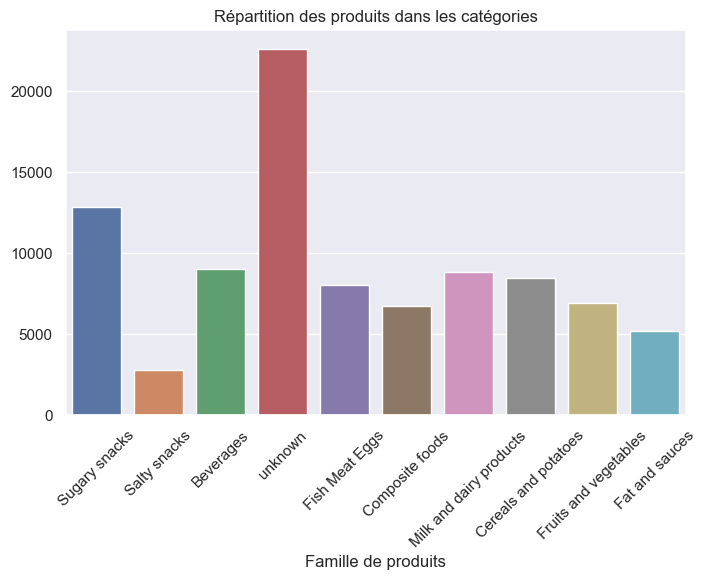

In [1121]:
data_component.loc[data_component['pnns_groups_1'] == 'fruits-and-vegetables', 'pnns_groups_1'] = 'Fruits and vegetables'
data_component.loc[data_component['pnns_groups_1'] == 'sugary-snacks', 'pnns_groups_1'] = 'Sugary snacks'
data_component.loc[data_component['pnns_groups_1'] == 'salty-snacks', 'pnns_groups_1'] = 'Salty snacks'
data_component.loc[data_component['pnns_groups_1'] == 'cereals-and-potatoes', 'pnns_groups_1'] = 'Cereals and potatoes'
tab = sbn.countplot(data=data_component, x="pnns_groups_1")
plt.xticks(rotation=45)
plt.xlabel("Famille de produits")
plt.ylabel("")
plt.title("Répartition des produits dans les catégories")
plt.show()

On a des valeurs négatives dans la plupart des colonnes, on va donc supprimer les lignes, car en aucun cas on ne peut avoir de lignes avec des valeurs négatives.
### Correction de valeurs inférieures à 0 et Correction de valeurs supérieures à 100

In [1122]:
# Traitement des erreurs x1000
data_component.loc[data_component['salt_100g'] > 999, 'salt_100g'] = data_component['salt_100g'] / 1000
# Traitement des outliers supérieurs à 100
data_component.loc[data_component['salt_100g'] > 100, 'salt_100g'] = 100
# Traitement du sodium qui dépasse leur valeur max
data_component.loc[data_component['salt_100g'] == 100, 'sodium_100g'] = 38.758
data_component.loc[(data_component['sodium_100g'] > 40), 'sodium_100g'] = data_component['salt_100g']*38.758/100

### Traitement du SEL effectué

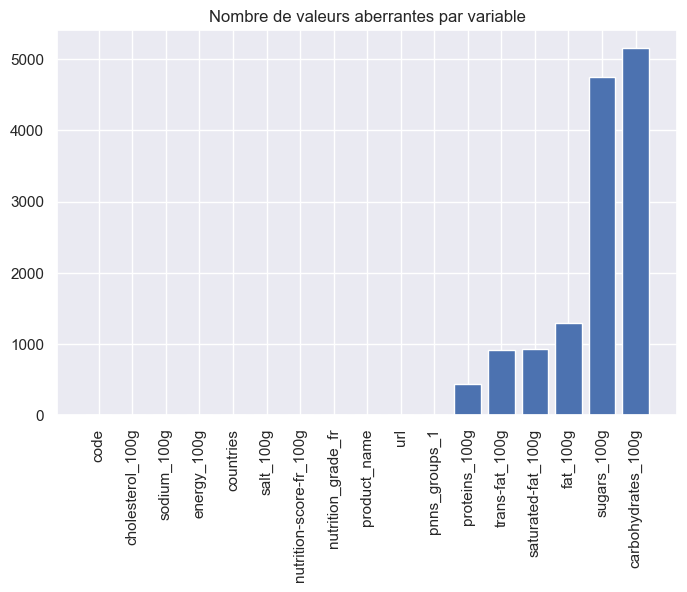

In [1123]:
numeric_cols = [x for x in data_component.columns.to_list() if x.endswith('_100g')]
numeric_cols.remove('energy_100g')
numeric_cols.remove('sodium_100g')
numeric_cols.remove('nutrition-score-fr_100g')

valeur_aberrante = data_component[data_component[numeric_cols] > 100].sum()
valeur_aberrante = valeur_aberrante.sort_values(ascending=True)
plt.bar(x=valeur_aberrante.keys(), height=valeur_aberrante.values)
plt.xticks(ticks=valeur_aberrante.index, rotation=90)
plt.title("Nombre de valeurs aberrantes par variable")
plt.show()

for col in numeric_cols:
    data_component.loc[(data_component[col] < 0) | (data_component[col] > 100), col] = np.NaN

Pour l'énergie la maximum est 900 kcal/100g

In [1124]:
print("Nombre de d'énergies aberrantes : ", data_component.loc[data_component['energy_100g'] > 900, 'energy_100g'].count())

Nombre de d'énergies aberrantes :  148001


Cela fait beaucoup de valeurs dépassant le seuil maximum de kcal pour 100g d'un produit.

In [1125]:
data_component.loc[data_component['energy_100g'] > 900, ['product_name', 'url', 'energy_100g']].sort_values(by='energy_100g', ascending=False)

product_name  \
212928                                        Pois cassés   
313506                 Nusco, Chocolate Spread, Chocolate   
249101  Légume Noisettes Carottes, 500 Grammes, Marque...   
112681                     Premium Extra Virgin Olive Oil   
119184               Sophia, Italian Drink, Squeezed Lime   
...                                                   ...   
211015                          Gnocchi - Pommes de terre   
312147                             Ckub thon oeufs mimosa   
227809                               Wrap jambon tzatziki   
238827                       6 merguez de volailles halal   
219341                                      12 mini-wraps   

                                                      url  energy_100g  
212928  http://world-fr.openfoodfacts.org/produit/3257...    3251373.0  
313506  http://world-fr.openfoodfacts.org/produit/8710...     231199.0  
249101  http://world-fr.openfoodfacts.org/produit/3661...     182764.0  
112681  http://world-fr.openfoodfacts.org/produit/0201...     110579.0  
119184  http://world-fr.openfoodfacts.org/produit/0619...      94140.0  
...                                                   ...          ...  
211015  http://world-fr.openfoodfacts.org/produit/3256...        901.0  
312147  http://world-fr.openfoodfacts.org/produit/8480...        901.0  
227809  http://world-fr.openfoodfacts.org/produit/3350...        901.0  
238827  http://world-fr.openfoodfacts.org/produit/3560...        901.0  
219341  http://world-fr.openfoodfacts.org/produit/3270...        901.0  

[148001 rows x 3 columns]

In [1126]:
data_component.loc[data_component['product_name'] == 'Pois cassés', 'energy_100g'] = 777.1

L'énergie des Pois cassés était en fait en Joules, donc je l'ai convertie en 1 kcal = 4.184 kjoule


In [1127]:
data_component.loc[(data_component['energy_100g'] > 900) & (data_component['energy_100g'] < 100000), 'energy_100g'] /= 4.184
print("Nombre de d'énergies incohérentes : ", data_component[data_component['energy_100g'] > 900].shape[0])

Nombre de d'énergies incohérentes :  553


Je vais mettre à NaN le reste des énergies

In [1128]:
data_component[data_component['energy_100g'] > 900] = np.NaN

Pour le score de nutrition celui-ci est compris entre -15 et 40

In [1129]:
print("Nombre de nutriscore ne respectant pas l'échelle classique : ", data_component[(data_component['nutrition-score-fr_100g'] < -15) | (data_component['nutrition-score-fr_100g'] > 40)].shape[0])

Nombre de nutriscore ne respectant pas l'échelle classique :  0


### Analyse des valeurs dépassant les borners de 1.5 * écart interquatile

### Gestion des outliers bas et haut par catégorie pour éviter les erreurs

In [1130]:
def remove_outlier_iqr(dataframe, delete_on=None):
    """
    Permet de supprimer les outliers des colonnes numériques du dataframe 'dataframe'.
    La méthode de l'écart interquartile x 1.5 est utilisé pour délimiter les valeurs extrêmes.
    :param DataFrame dataframe: Dataframe qui sera modifié
    :param bool delete_on: si True alors les lignes seront supprimées sinon les valeurs seront remplacées par NaN
    """
    # récupère les noms de colonnes numériques
    numeric = dataframe._get_numeric_data()
    for column in numeric.columns:
        # Calcul de l'écart interquartile
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        limit = IQR * 1.5
        # Remplace les valeurs des lignes supérieures et inférieures à l'écart x 1.5 par Nan
        if delete_on is not None:
            if delete_on:
                dataframe.drop(dataframe[(dataframe[column] > Q3 + limit) | (dataframe[column] < Q1 - limit)].index, inplace=True)
            else:
                dataframe[(dataframe[column] > Q3 + limit) | (dataframe[column] < Q1 - limit)] = np.NaN
        else:
            return "Veuillez renseigner le paramètre delete_on"

    return dataframe

# Par groupe de produit
product_groups = data_component.groupby(by='pnns_groups_1')['pnns_groups_1'].count().index.to_list()
for product_group in product_groups:
        data_component[data_component['pnns_groups_1'] == product_group] = remove_outlier_iqr(dataframe=data_component[data_component['pnns_groups_1'] == product_group], delete_on=False)

C:\Users\vkubi\AppData\Local\Temp\ipykernel_20748\212366393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[(dataframe[column] > Q3 + limit) | (dataframe[column] < Q1 - limit)] = np.NaN


## Somme des sous-composants

In [1131]:
print("Nombre de valeurs manquantes avant calcul avec la formule : ", data_component['fat_100g'].isna().sum())
data_component['fat_100g'].fillna(data_component['saturated-fat_100g'] + data_component['trans-fat_100g'] + data_component['cholesterol_100g'], inplace=True)
data_component.loc[data_component.eval("`saturated-fat_100g` + `trans-fat_100g` + `cholesterol_100g`") > 100, 'fat_100g'] = np.NaN
print("Nombre de valeurs manquantes après calcul avec la formule :", data_component['fat_100g'].isna().sum())

Nombre de valeurs manquantes avant calcul avec la formule :  96592
Nombre de valeurs manquantes après calcul avec la formule : 96463


In [1132]:
data_component[['fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g']].describe()

fat_100g  saturated-fat_100g  trans-fat_100g  cholesterol_100g
count  224175.000000       209434.000000   141992.000000     142771.000000
mean       12.409565            4.978719        0.064685          0.019965
std        17.011425            7.387837        0.926793          0.358520
min         0.000000            0.000000        0.000000          0.000000
25%         0.000000            0.000000        0.000000          0.000000
50%         4.800000            1.790000        0.000000          0.000000
75%        20.000000            7.140000        0.000000          0.020000
max       100.000000          100.000000      100.000000         95.238000

## Nettoyage des valeurs manquantes
### Suppression des données avec le nom manquant

In [1133]:
print("Nombres d'individus avant suppression : ", data_component.shape[0])
data_component = data_component.dropna(subset=['url'])
print("Nombres d'individus après suppression : ", data_component.shape[0])

Nombres d'individus avant suppression :  320638
Nombres d'individus après suppression :  299401


In [1134]:
data_component['product_name'] = data_component['product_name'].fillna(data_component['url'].str.split(pat='/', n=1))

Nombre total de colonnes :  17


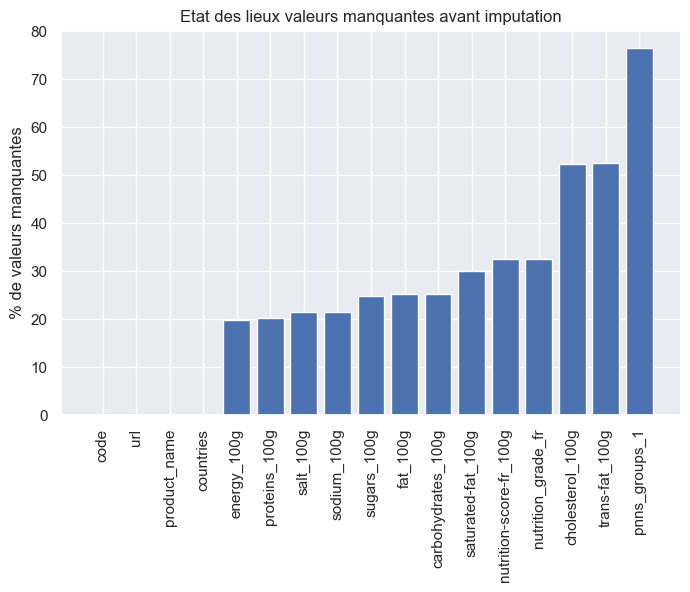

In [1135]:
percent_null = data_component.isnull().sum()*100/len(data_component)
percent_null = percent_null.sort_values(ascending=True)
print("Nombre total de colonnes : ", data_component.shape[1])
plt.bar(percent_null.keys(), percent_null.values)
plt.xticks(rotation=90)
plt.ylabel("% de valeurs manquantes")
plt.title("Etat des lieux valeurs manquantes avant imputation")
plt.show()

In [1136]:
data_component.loc[data_component['pnns_groups_1'].isna(), 'pnns_groups_1'] = ''

Nombre total de colonnes :  17


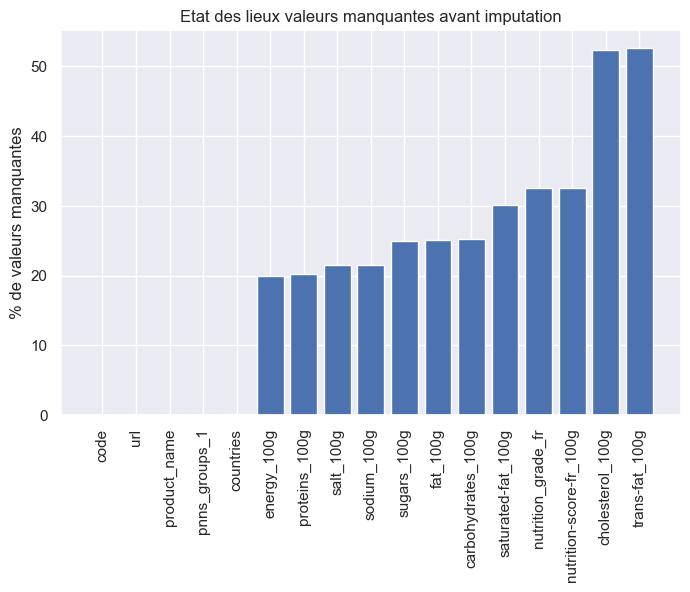

In [1137]:
percent_null = data_component.isnull().sum()*100/len(data_component)
percent_null = percent_null.sort_values(ascending=True)
print("Nombre total de colonnes : ", data_component.shape[1])
plt.bar(percent_null.keys(), percent_null.values)
plt.xticks(rotation=90)
plt.ylabel("% de valeurs manquantes")
plt.title("Etat des lieux valeurs manquantes avant imputation")
plt.show()

Les individus sans URLs ne peuvent pas être conservés, ils ne sont pas enregistrés sur le site web.
### Moyenne par catégorie de produit pour Trans-fat
Je set les pnns_groups_1 vides à ''

In [1138]:
data_component['trans-fat_100g'] = data_component['trans-fat_100g'].fillna(data_component.groupby('pnns_groups_1')['trans-fat_100g'].transform('mean'))

## Imputation avec IterativeImputer sur les données pour déterminer 'carbohydrates_100g', 'proteins_100g', 'fat_100g'

In [1139]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imput_cols = ['cholesterol_100g', 'carbohydrates_100g', 'fat_100g', 'sugars_100g', 'saturated-fat_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']
iter_imputer = IterativeImputer(missing_values=np.NaN, initial_strategy='mean', max_iter=30, max_value=[100, 100, 100, 100, 100, 100, 40, 40], min_value=[0, 0, 0, 0, 0, 0, 0, -15])
temp_data_component = data_component.copy(deep=True)
temp_data_component.loc[:, imput_cols] = iter_imputer.fit_transform(temp_data_component[imput_cols])
data_component[imput_cols] = temp_data_component[imput_cols]

## Imputation avec KNNImputer
Est apparemment efficace lorsque les données à imputer sont < 100k. Il n'y a que la colonne saturated-fat_100g qui est dans ce cas.
Je vais donc utiliser Iterative à nouveau sur toutes les colonnes sauf la dernière puis utiliser KNN pour saturated-fat_100g
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

### Correction de valeur nulle avec formule de calcul de l'énergie

En premier lieu suppression des lignes pour lesquelles les colonnes sont vides

In [1140]:
data_component = data_component.dropna(subset=['energy_100g', 'proteins_100g', 'carbohydrates_100g', 'fat_100g'] )

In [1141]:
print('Nombre de valeurs vides avant imputation : ', data_component['energy_100g'].isna().sum())
data_component['energy_100g'] = data_component['energy_100g'].fillna(data_component.proteins_100g*4 + data_component.carbohydrates_100g*4 + data_component.fat_100g*9)

Nombre de valeurs vides avant imputation :  0


## Imputation des valeurs d'energie qui ont dépassé 900

In [1142]:
print("Nombre de valeur de energie dont le calcul a dépassé 900 : ", len(data_component[data_component['energy_100g'] > 900]))
data_component.loc[data_component['energy_100g'] > 900, 'energy_100g'] = np.NaN

Nombre de valeur de energie dont le calcul a dépassé 900 :  0


In [1143]:
# Imputation des valeurs nulles
energy_formula_cols = ['carbohydrates_100g', 'fat_100g', 'proteins_100g', 'energy_100g']
energy_imputer = IterativeImputer(missing_values=np.NaN, initial_strategy='mean', max_iter=10, max_value=[100, 100, 100, 900], min_value=[0, 0, 0, 0])
energy_data_component = data_component.copy(deep=True)
energy_data_component.loc[:, energy_formula_cols] = energy_imputer.fit_transform(energy_data_component[energy_formula_cols])
data_component[energy_formula_cols] = energy_data_component[energy_formula_cols]

### J'impute le grade nutritionnel en me basant sur le nutri-score que je viens d'imputer

In [1144]:
data_component['nutrition_grade_fr'] = data_component['nutrition_grade_fr'].fillna(pd.cut(x=data_component['nutrition-score-fr_100g'], labels=['a', 'b', 'c', 'd', 'e'], bins=[-15,-1,2,10,18,40], right=False))

Nombre total de colonnes :  17


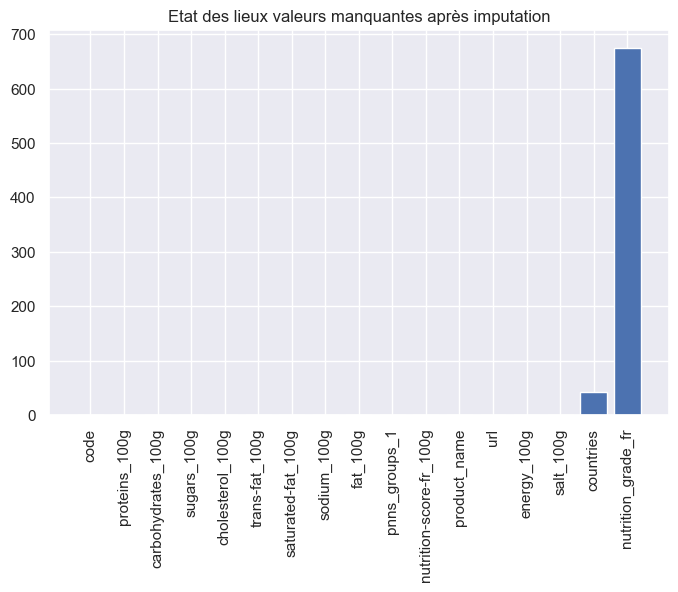

In [1145]:
percent_null = data_component.isnull().sum()
percent_null = percent_null.sort_values(ascending=True)
print("Nombre total de colonnes : ", data_component.shape[1])
plt.bar(percent_null.keys(), percent_null.values)
plt.xticks(rotation=90)
plt.title("Etat des lieux valeurs manquantes après imputation")
plt.show()

In [1146]:
data_component.to_csv('data_clean.csv', sep='\t', index_label='index')